Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [44]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Rescaling, BatchNormalization

In [2]:
## mounting the google drive:
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [7]:
##creating training dataset using tf.keras.set_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(img_width, img_height),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## creating validation dataset using tf.keras.preprocessing.image_dataset_from_director
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(img_width, img_height),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Listing out all the classes of skin cancer and storing them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Path list of all the train images , required to populate the dataframe

In [11]:
from glob import glob

In [57]:
# creating path list in directory
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]


In [59]:
# getting the classes of each image dataset based on the folder name as per the skin cancer name
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*', '*.jpg'))]

In [14]:
# creating a dictionary to prepare a dataframe
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [15]:
original_df.head()

Path              Label
0  /content/gdrive/MyDrive/Skin cancer ISIC The I...  actinic keratosis
1  /content/gdrive/MyDrive/Skin cancer ISIC The I...  actinic keratosis
2  /content/gdrive/MyDrive/Skin cancer ISIC The I...  actinic keratosis
3  /content/gdrive/MyDrive/Skin cancer ISIC The I...  actinic keratosis
4  /content/gdrive/MyDrive/Skin cancer ISIC The I...  actinic keratosis

In [16]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

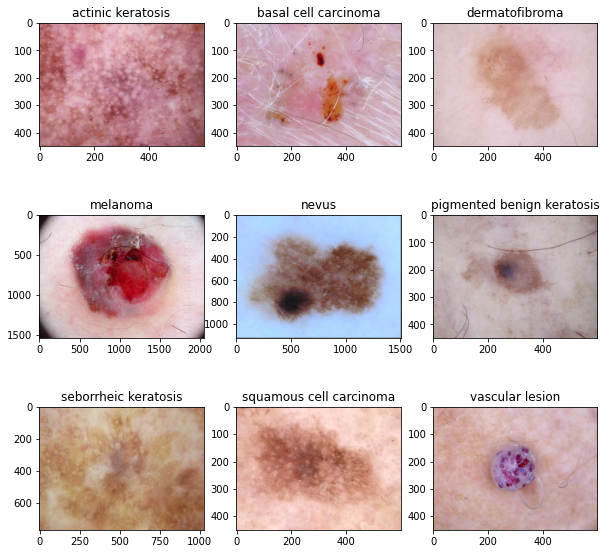

In [17]:
# Ploting graph to visualize the images from each of the 9 classes
import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model (M1 Model)
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using Rescaling layer to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [19]:
### model architicture 
# we shall be using padding so the shape of data is not impacted
#Creating sequential model
model=Sequential()
#rescaling layer
model.add(Rescaling(1./255,input_shape=(img_width,img_height,3)))
#Convolution layer with 32 neurons
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
#Maxpool layer
model.add(MaxPooling2D(pool_size=(2,2)))
#Convolution layer with 64 neurons
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding='same'))
#Maxpool layer
model.add(MaxPooling2D(pool_size=(2,2)))
#Convolution layer with 128 neurons
model.add(Conv2D(128, kernel_size=(3,3), activation='relu',padding='same'))
#Maxpool layer
model.add(MaxPooling2D(pool_size=(2,2)))
#Flatten layer to flatten data 
model.add(Flatten())
#fully connencted dense layer
model.add(Dense(128, activation='relu'))
#sofmax layer for classification
model.add(Dense(9,activation='softmax'))

### Compile the model
Choosing an appropirate optimiser and loss function for model training 

In [20]:
### compiling model with adam as optimiser and sparse_categorical_crossentropy as loss
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Train the model

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 605s 2s/step - loss: 2.0924 - accuracy: 0.2059 - val_loss: 2.0280 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 1.9009 - accuracy: 0.2857 - val_loss: 1.7241 - val_accuracy: 0.4295
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.6639 - accuracy: 0.4057 - val_loss: 1.5801 - val_accuracy: 0.4810
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4296 - accuracy: 0.4989 - val_loss: 1.3909 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3021 - accuracy: 0.5541 - val_loss: 1.3503 - val_accuracy: 0.5593
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1897 - accuracy: 0.5843 - val_loss: 1.3520 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1583 - accuracy: 0.5921 - val_loss: 1.3630 - val_accuracy: 0.5749
Epoch 8/20
56

### Visualizing training results

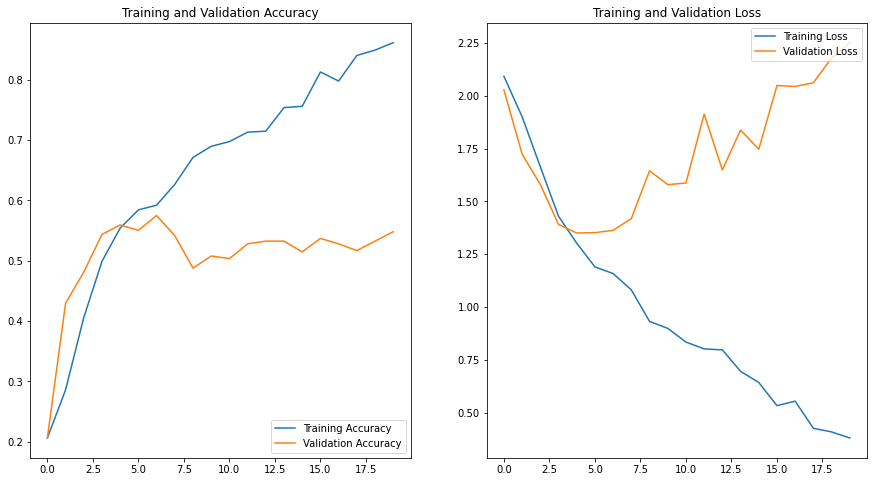

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### As seen above there  training accuaracy is very high but validation accuracy is very less ~54% , so it can be concluded that model is overfitting. It may be due to less amount of data as we know CNN require a large amount of data for learning.

# M2 Model with Data Augumentation

In [24]:
# data augumentation strategy. 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
  layers.experimental.preprocessing.RandomRotation(0.4),
  layers.experimental.preprocessing.RandomZoom(0.3)
])

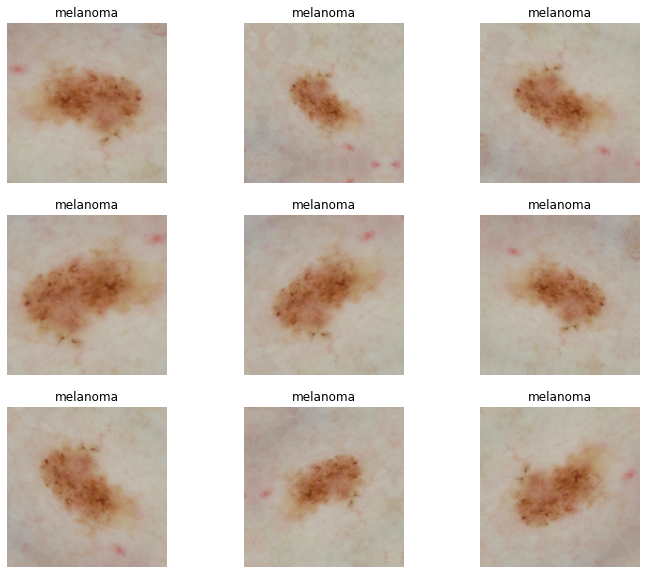

In [25]:
# visualizing augmentation strategy for one instance of training image.
plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")
plt.show()

### Creating the model, compile and train the model


In [26]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# Model is same as in M1 with a addition of data Augumentation layer and dropout after each convolution layer and flatten. 
# Degree of dropout is kept more after flatten layer as it is expected that there shall be more no. of redundancies after flatten layer comapred to convolution layer.
model=Sequential([data_augmentation])
model.add(Rescaling(1./255,input_shape=(img_width,img_height,3)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9,activation='softmax'))

### Compiling the model

In [27]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


### Training the model

In [28]:
## training
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 74ms/step - loss: 2.3883 - accuracy: 0.1825 - val_loss: 2.0376 - val_accuracy: 0.2864
Epoch 2/20
56/56 [==============================] - 4s 70ms/step - loss: 1.9799 - accuracy: 0.2489 - val_loss: 1.8889 - val_accuracy: 0.3378
Epoch 3/20
56/56 [==============================] - 4s 70ms/step - loss: 1.8575 - accuracy: 0.3209 - val_loss: 1.8416 - val_accuracy: 0.3154
Epoch 4/20
56/56 [==============================] - 4s 71ms/step - loss: 1.8094 - accuracy: 0.3421 - val_loss: 1.7813 - val_accuracy: 0.3781
Epoch 5/20
56/56 [==============================] - 4s 72ms/step - loss: 1.6912 - accuracy: 0.3834 - val_loss: 1.5730 - val_accuracy: 0.4251
Epoch 6/20
56/56 [==============================] - 4s 68ms/step - loss: 1.6209 - accuracy: 0.4213 - val_loss: 1.5492 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.5701 - accuracy: 0.4520 - val_loss: 1.4654 - val_accuracy: 0.4877
Epoch 8/20
56

### Visualizing the results

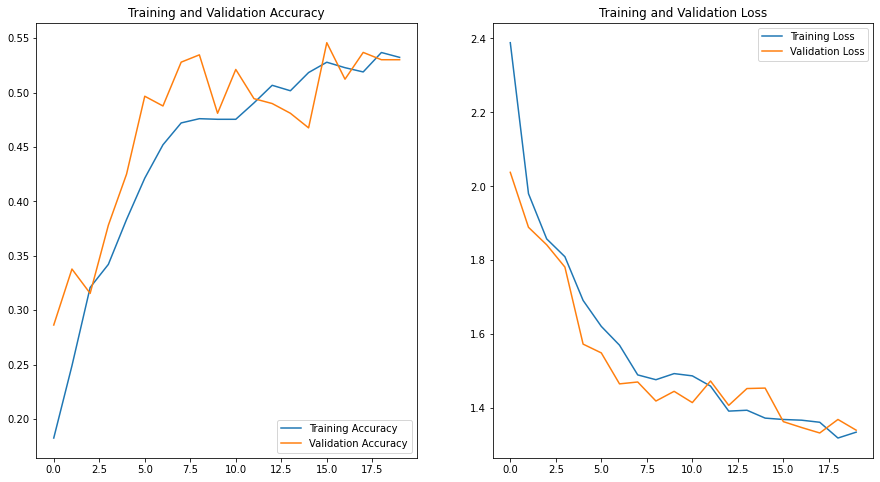

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### In terms of overfitting now training and validation data is having alomst same accuracy, however training accuracy of model is very less ~53%. Thus model in underfitting. Reason for same may be less no. of data. 

# M3 model with Augumentor Library for Class Imbalance

#### Lets check distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [30]:
## creating dictionary with count of all the classes
image_dict = {}
for classname in class_names:
    image_dict[classname] = len(list(data_dir_train.glob(classname+'/*.jpg')))   
print(image_dict) 

{'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


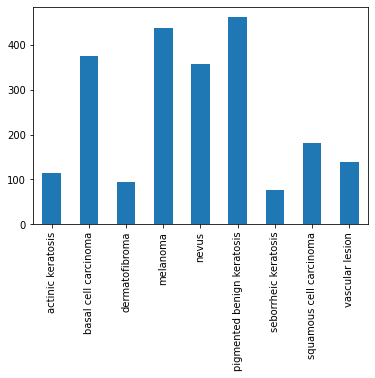

In [31]:
#visualizing distribution
class_dist=pd.DataFrame([image_dict]).T
class_dist.rename(columns={0:'Count'}, inplace=True)
class_dist.Count.plot.bar()
plt.show()

As seen  above 'seborrheic keratosis' class has the least no. of samples and 'pigmented benign keratosis' has the maximum no. of samples. Further, there is a very high degree of class imbalance which may be leading to underfitting.


#### Rectifying the class imbalance
#### Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.


In [32]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6E64170AD0>: 100%|██████████| 500/500 [00:20<00:00, 23.85 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6E0C08BDD0>: 100%|██████████| 500/500 [00:22<00:00, 22.72 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DF9194FD0>: 100%|██████████| 500/500 [00:21<00:00, 22.94 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6E0C0AD050>: 100%|██████████| 500/500 [01:30<00:00,  5.54 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F6DF9148D50>: 100%|██████████| 500/500 [01:13<00:00,  6.79 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6E74A92E50>: 100%|██████████| 500/500 [00:18<00:00, 26.96 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6E0C6151D0>: 100%|██████████| 500/500 [00:42<00:00, 11.83 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6E642A6690>: 100%|██████████| 500/500 [00:17<00:00, 27.88 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6E6430F310>: 100%|██████████| 500/500 [00:18<00:00, 27.22 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
from glob import glob

In [58]:
#path list of new directory in output folder
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [38]:
#dictionary with path in directory
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [39]:
#converting into dataframe 
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

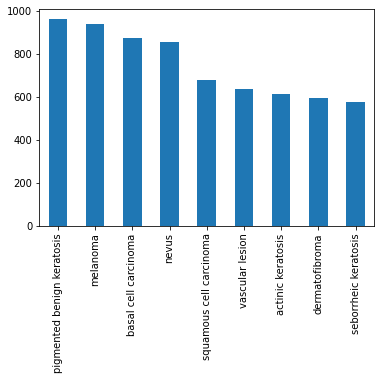

In [40]:
# distribution of classes after including new data
new_df['Label'].value_counts().plot.bar()
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance and increase data also.

####  Training the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a new training dataset

In [42]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a new validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating your model M3

In [49]:
# Model architecture is similar to M2 only difference is more data shall be fed now to model
model=Sequential()
model.add(Rescaling(1./255,input_shape=(img_width,img_height,3)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9,activation='softmax'))

#### Compiling  model

In [50]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                 

#### Training model

In [52]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
169/169 [==============================] - 32s 183ms/step - loss: 2.2379 - accuracy: 0.1753 - val_loss: 1.9807 - val_accuracy: 0.2754
Epoch 2/40
169/169 [==============================] - 32s 181ms/step - loss: 1.7887 - accuracy: 0.3225 - val_loss: 1.6448 - val_accuracy: 0.3838
Epoch 3/40
169/169 [==============================] - 32s 181ms/step - loss: 1.6297 - accuracy: 0.3819 - val_loss: 1.5381 - val_accuracy: 0.4120
Epoch 4/40
169/169 [==============================] - 32s 182ms/step - loss: 1.5492 - accuracy: 0.4117 - val_loss: 1.5750 - val_accuracy: 0.4105
Epoch 5/40
169/169 [==============================] - 32s 181ms/step - loss: 1.4614 - accuracy: 0.4405 - val_loss: 1.4260 - val_accuracy: 0.4462
Epoch 6/40
169/169 [==============================] - 32s 181ms/step - loss: 1.4183 - accuracy: 0.4670 - val_loss: 1.3581 - val_accuracy: 0.4870
Epoch 7/40
169/169 [==============================] - 32s 182ms/step - loss: 1.3691 - accuracy: 0.4761 - val_loss: 1.2981 - val_ac

#### Visualizing the model results

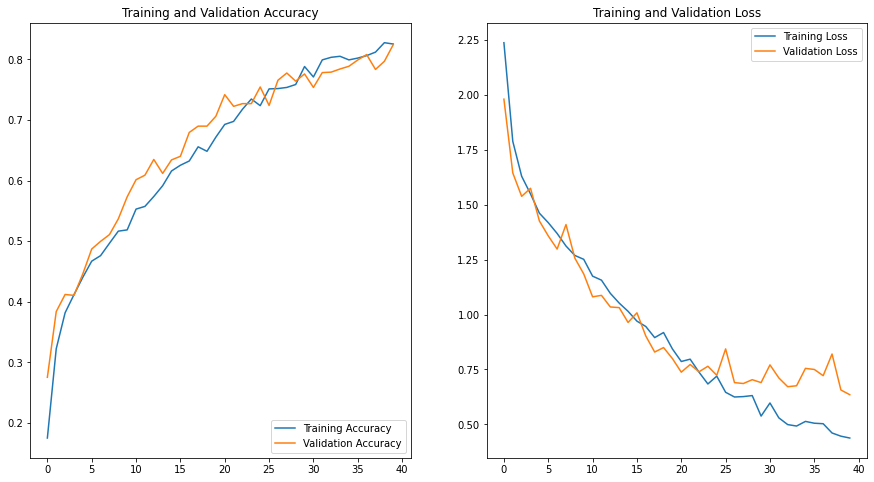

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As compared to 2nd model now validation accuracy has significantly gone up i.e up to 82% which is almost similar to train accuracy and now model is more robust for real unseen data. Further, we can increase epochs to 50 -60 to get best results with more computational cost. One important fact to notice here is that till approx. 25 epochs validation acc. is more than training acc., which may be due to implementation of dropouts during training which are not implemented while testing model.